<a href="https://colab.research.google.com/github/nisha1365/CTS-20-Projects/blob/main/aorta_grad_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OSIC Pulmonary Fibrosis Progression
# Predict lung function decline

Predict a patient’s severity of decline in lung function based on a CT scan of their lungs. Lung function is assessed based on output from a spirometer, which measures the forced vital capacity (FVC), i.e. the volume of air exhaled.

In the dataset, you are provided with a baseline chest CT scan and associated clinical information for a set of patients. A patient has an image acquired at time Week = 0 and has numerous follow up visits over the course of approximately 1-2 years, at which time their FVC is measured.

In the training set, you are provided with an anonymized, baseline CT scan and the entire history of FVC measurements.
In the test set, you are provided with a baseline CT scan and only the initial FVC measurement. You are asked to predict the final three FVC measurements for each patient, as well as a confidence value in your prediction.
There are around 200 cases in the public & private test sets, combined. This is split roughly 15-85 between public-private.

Since this is real medical data, you will notice the relative timing of FVC measurements varies widely. The timing of the initial measurement relative to the CT scan and the duration to the forecasted time points may be different for each patient. This is considered part of the challenge of the competition. To avoid potential leakage in the timing of follow up visits, you are asked to predict every patient's FVC measurement for every possible week. Those weeks which are not in the final three visits are ignored in scoring.

Files


train.csv - the training set, contains full history of clinical information
test.csv - the test set, contains only the baseline measurement
train/ - contains the training patients' baseline CT scan in DICOM format
test/ - contains the test patients' baseline CT scan in DICOM format

Columns
train.csv and test.csv
Patient- a unique Id for each patient (also the name of the patient's DICOM folder)
Weeks- the relative number of weeks pre/post the baseline CT (may be negative)
FVC - the recorded lung capacity in ml
Percent- a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
Age
Sex
SmokingStatus

Albumentations is a Python library for image augmentation. Image augmentation is used in deep learning and computer vision tasks to increase the quality of trained models. The purpose of image augmentation is to create new training samples from the existing data.

In [ ]:
!pip install albumentations==0.4.6

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [ ]:
!pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 2.2 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3


PyTorch is a fully featured framework for building deep learning models, which is a type of machine learning that's commonly used in applications like image recognition and language processing. 

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-zmycy3hy
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-zmycy3hy
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 8523324c116dcf7be6bddb73bf4eb1779ef6e611
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 5.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 913.5 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.8 MB/s eta 0:00:0000:0100:01
  

### Importing libraries

In [ ]:
import os
import time
import io
import base64

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import matplotlib.colors as mpl_colors
import seaborn as sns

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from albumentations.pytorch import ToTensor, ToTensorV2 
from albumentations import (HorizontalFlip,
                            VerticalFlip,
                            Normalize,
                            Compose)

from segmentation_models_pytorch import Unet

from IPython.display import HTML
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore")

### Helper functions

In [ ]:



def get_one_slice_data(img_name: str,
                       mask_name: str,
                       root_imgs_path: str = "images/",
                       root_masks_path: str = "masks/",) -> np.ndarray:

    img_path = os.path.join(root_imgs_path, img_name)
    mask_path = os.path.join(root_masks_path, mask_name)
    one_slice_img = cv2.imread(img_path)#[:,:,0] uncomment for grayscale
    one_slice_mask = cv2.imread(mask_path)
    one_slice_mask[one_slice_mask < 240] = 0  # remove artifacts
    one_slice_mask[one_slice_mask >= 240] = 255

    return one_slice_img, one_slice_mask




def get_id_predictions(net: nn.Module,
                       ct_scan_id_df: pd.DataFrame,
                       root_imgs_dir: str,
                       treshold: float = 0.3) -> list:

    """
    Factory for getting predictions and storing them and images in lists as uint8 images.
    Params:
        net: model for prediction.
        ct_scan_id_df: df with unique patient id.
        root_imgs_dir: root path for images.
        treshold: threshold for probabilities.
    """
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    images = []
    predictions = []
    net.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("device:", device)
    with torch.no_grad():
        for idx in range(len(ct_scan_id_df)):
            img_name = ct_scan_id_df.loc[idx, "ImageId"]
            path = os.path.join(root_imgs_dir, img_name)

            img_ = cv2.imread(path)
    
            img = Normalize().apply(img_)
            tensor = torch.FloatTensor(img).permute(2, 0, 1).unsqueeze(0)
            prediction = net.forward(tensor.to(device))
            prediction = prediction.cpu().detach().numpy()
            prediction = prediction.squeeze(0).transpose(1, 2, 0)
            prediction = sigmoid(prediction)
            prediction = (prediction >= treshold).astype(np.float32)

            predictions.append((prediction * 255).astype("uint8"))
            images.append(img_)

    return images, predictions


# Save image in original resolution
# helpful link - https://stackoverflow.com/questions/34768717/matplotlib-unable-to-save-image-in-same-resolution-as-original-image

def get_overlaid_masks_on_image(
                one_slice_image: np.ndarray,
                one_slice_mask: np.ndarray, 
                w: float = 512,
                h: float = 512, 
                dpi: float = 100,
                write: bool = False,
                path_to_save: str = '/content/',
                name_to_save: str = 'img_name'):
    """overlap masks on image and save this as a new image."""

    path_to_save_ = os.path.join(path_to_save, name_to_save)
    lung, heart, trachea = [one_slice_mask[:, :, i] for i in range(3)]
    figsize = (w / dpi), (h / dpi)
    fig = plt.figure(figsize=(figsize))
    fig.add_axes([0, 0, 1, 1])
 
    # image
    plt.imshow(one_slice_image, cmap="bone")

    # overlaying segmentation masks
    plt.imshow(np.ma.masked_where(lung == False, lung),
            cmap='cool', alpha=0.3)
    plt.imshow(np.ma.masked_where(heart == False, heart),
            cmap='autumn', alpha=0.3)
    plt.imshow(np.ma.masked_where(trachea == False, trachea),
               cmap='autumn_r', alpha=0.3) 

    #plt.axis("off")                                            ## dont work in kaggle kernel
    fig.axes[0].get_xaxis().set_visible(False)                  ## work in kaggle kernel
    fig.axes[0].get_yaxis().set_visible(False)
    

    fig.savefig(f"{path_to_save_}.png",bbox_inches='tight', 
                pad_inches=0, dpi=dpi,  format="png")
    
    if write:
        plt.close()
    else:
        plt.show()
        
def get_overlaid_masks_on_full_ctscan(ct_scan_id_df: pd.DataFrame, 
                                      path_to_save: str,
                                      root_imgs_dir: str,
                                      root_masks_dir: str,
                                     ):
    """
    Creating images with overlaid masks on each slice of CT scan.
    Params:
         ct_scan_id_df: df with unique patient id.
         path_to_save: path to save images.
    """
    num_slice = len(ct_scan_id_df)
    for slice_ in range(num_slice):
        img_name = ct_scan_id_df.loc[slice_, "ImageId"]
        mask_name = ct_scan_id_df.loc[slice_, "MaskId"]
        one_slice_img, one_slice_mask = get_one_slice_data(img_name, mask_name,
                                                           root_imgs_dir, root_masks_dir)
        get_overlaid_masks_on_image(one_slice_img,
                                one_slice_mask,
                                write=True, 
                                path_to_save=path_to_save,
                                name_to_save=str(slice_)
                                )

def create_video(path_to_imgs: str, video_name: str, framerate: int):
    """
    Create video from images.
    Params:
        path_to_imgs: path to dir with images.
        video_name: name for saving video.
        framerate: num frames per sec in video.
    """
    img_names = sorted(os.listdir(path_to_imgs), key=lambda x: int(x[:-4]))  # img_name must be numbers
    img_path = os.path.join(path_to_imgs, img_names[0])
    frame_width, frame_height, _ = cv2.imread(img_path).shape
    fourc = cv2.VideoWriter_fourcc(*'XVID')           ## MP4V - dont work in kaggle kernel
    video = cv2.VideoWriter(video_name + ".avi",      ##'mp4' 
                            fourc, 
                            framerate, 
                            (frame_width, frame_height))

    for img_name in img_names:
        img_path = os.path.join(path_to_imgs, img_name)
        image = cv2.imread(img_path)
        video.write(image)
            
    #cv2.destroyAllWindows()
    video.release()

    
def compute_scores_per_classes(model,
                               dataloader,
                               classes):
    """
    Compute Dice and Jaccard coefficients for each class.
    Params:
        model: neural net for make predictions.
        dataloader: dataset object to load data from.
        classes: list with classes.
        Returns: dictionaries with dice and jaccard coefficients for each class for each slice.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs)
            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
            
            dice_scores = dice_coef_metric_per_classes(logits, targets)
            iou_scores = jaccard_coef_metric_per_classes(logits, targets)

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    return dice_scores_per_classes, iou_scores_per_classes


# loss
def dice_coef_metric_per_classes(probabilities: np.ndarray,
                                    truth: np.ndarray,
                                    treshold: float = 0.5,
                                    eps: float = 1e-9,
                                    classes: list = ['lung', 'heart', 'trachea']) -> np.ndarray:
    """
    Calculate Dice score for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with dice scores for each class.
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = 2.0 * (truth_ * prediction).sum()
            union = truth_.sum() + prediction.sum()
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)
                
    return scores


def jaccard_coef_metric_per_classes(probabilities: np.ndarray,
               truth: np.ndarray,
               treshold: float = 0.5,
               eps: float = 1e-9,
               classes: list = ['lung', 'heart', 'trachea']) -> np.ndarray:
    """
    Calculate Jaccard index for data batch and for each class.
    Params:
        probobilities: model outputs after activation function.
        truth: model targets.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        classes: list with name classes.
        Returns: dict with jaccard scores for each class."
    """
    scores = {key: list() for key in classes}
    num = probabilities.shape[0]
    num_classes = probabilities.shape[1]
    predictions = (probabilities >= treshold).astype(np.float32)
    assert(predictions.shape == truth.shape)

    for i in range(num):
        for class_ in range(num_classes):
            prediction = predictions[i][class_]
            truth_ = truth[i][class_]
            intersection = (prediction * truth_).sum()
            union = (prediction.sum() + truth_.sum()) - intersection + eps
            if truth_.sum() == 0 and prediction.sum() == 0:
                 scores[classes[class_]].append(1.0)
            else:
                scores[classes[class_]].append((intersection + eps) / union)

    return scores


# visualizer
def show_data_augmentations(img_tensor: torch.Tensor,
                            mask_tensor: torch.Tensor,
                            mean: tuple = (0.485, 0.456, 0.406),
                            std: tuple = (0.229, 0.224, 0.225),
                            labels: list=["image", "lung", "heart", "trachea"]):
    
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = (img * std + mean).astype("float32")
    img = np.clip(img, 0, 1)
    mask = mask_tensor.numpy().transpose(1, 2, 0)
    data_to_plot = [img, *[mask[:,:, i] for i in range(3)]]

    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 8))
    for i, ax in enumerate(axes):
        ax.imshow(data_to_plot[i])
        ax.set_title(labels[i])

    plt.show()
    
    
def show_video(video_path: str):
    """
    show video in jupyter notebook, agent interaction in environment.
    Takes - path to video file.
    Returns - html video player in jupyter notebook.
    """  
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)

    return HTML(data='''<video alt="test" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4" /> </video>'''
    .format(encoded.decode('ascii')))


def get_color_info(classes: list = ['lung', 'heart', 'trachea']):

    def get_color(cmap):
        new_cmap = mpl_colors.LinearSegmentedColormap.from_list(
            (cmap.name, 0.0, 0.0,),
            cmap(np.linspace(0.0, 0.0, 100))
            )
        return new_cmap

    colormaps = [plt.get_cmap(cmap_name) for cmap_name in 
                ['cool', 'autumn', 'autumn_r']
                ]
    arr = np.linspace(0, 50, 100).reshape((10, 10))
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        cmap = get_color(colormaps[i])
        ax[i].axis('off')
        ax[i].imshow(arr, cmap=cmap)
        ax[i].set_title(classes[i], fontsize=15)

    fig.suptitle("Color definition", fontsize=20, y=0.99)
    fig.savefig(f"color_definition.png", bbox_inches='tight', 
                pad_inches=0.2, dpi=100, format="png")
    
    plt.savefig(f"color_definition.svg", bbox_inches='tight',
                pad_inches=0.2, dpi=100, format="svg")

config with global variables

In [ ]:
class GlobalConfig:
    def __init__(self):
        self.seed = 555
        self.path_to_csv = '../input/chest-ct-segmentation/train.csv'
        self.path_to_imgs_dir = '../input/chest-ct-segmentation/images/images'
        self.path_to_masks_dir = '../input/chest-ct-segmentation/masks/masks'
        self.pretrained_model_path = '../input/chest-ct-segmentation/pretrained_model/pretrained_model/model_100_epoch.pth'
        self.train_logs_path = '../input/chest-ct-segmentation/pretrained_model/pretrained_model/train_log_100_epoch.csv'


def seed_everything(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
config = GlobalConfig()
seed_everything(config.seed)

# Dataset and Dataloader

In [ ]:
class LungsDataset(Dataset):
    def __init__(self, 
                 imgs_dir: str,
                 masks_dir:str,
                 df: pd.DataFrame,
                 phase: str):
        """Initialization."""
        self.root_imgs_dir = imgs_dir
        self.root_masks_dir = masks_dir
        self.df = df
        self.augmentations = get_augmentations(phase)
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, "ImageId"]
        mask_name = self.df.loc[idx, "MaskId"]
        img_path = os.path.join(self.root_imgs_dir, img_name)
        mask_path = os.path.join(self.root_masks_dir, mask_name)
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        mask[mask < 240] = 0    # remove artifacts
        mask[mask > 0] = 1

        augmented = self.augmentations(image=img, 
                                       mask=mask.astype(np.float32))
        img = augmented['image']
        mask = augmented['mask'].permute(2, 0, 1)

        return img, mask


def get_augmentations(phase,
                   mean: tuple = (0.485, 0.456, 0.406),
                   std: tuple = (0.229, 0.224, 0.225),):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                VerticalFlip(p=0.5), 
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            #ToTensor(num_classes=3, sigmoid=False),
            ToTensorV2(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms


def get_dataloader(
    imgs_dir: str,
    masks_dir: str,
    path_to_csv: str,
    phase: str,
    batch_size: int = 8,
    num_workers: int = 6,
    test_size: float = 0.2,
):
    '''Returns: dataloader for the model training'''
    df = pd.read_csv(path_to_csv)
    

    train_df, val_df = train_test_split(df, 
                                          test_size=test_size, 
                                          random_state=69)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

    df = train_df if phase == "train" else val_df
    image_dataset = LungsDataset(imgs_dir, masks_dir, df, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader

# Loss and Metrics

In [ ]:
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Dice score for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: dice score aka f1.
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    """
    Calculate Jaccard index for data batch.
    Params:
        probobilities: model outputs after activation function.
        truth: truth values.
        threshold: threshold for probabilities.
        eps: additive to refine the estimate.
        Returns: jaccard score aka iou."
    """
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)


class Meter:
    '''factory for storing and updating iou and dice scores.'''
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []
    
    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        """
        Takes: logits from output model and targets,
        calculates dice and iou scores, and stores them in lists.
        """
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)
        
        self.dice_scores.append(dice)
        self.iou_scores.append(iou)
    
    def get_metrics(self) -> np.ndarray:
        """
        Returns: the average of the accumulated dice and iou scores.
        """
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou
    

class DiceLoss(nn.Module):
    """Calculate dice loss."""
    def __init__(self, eps: float = 1e-9):
        super(DiceLoss, self).__init__()
        self.eps = eps
        
    def forward(self,
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        
        num = targets.size(0)
        probability = torch.sigmoid(logits)
        probability = probability.view(num, -1)
        targets = targets.view(num, -1)
        assert(probability.shape == targets.shape)
        
        intersection = 2.0 * (probability * targets).sum()
        union = probability.sum() + targets.sum()
        dice_score = (intersection + self.eps) / union
        #print("intersection", intersection, union, dice_score)
        return 1.0 - dice_score
        
        
class BCEDiceLoss(nn.Module):
    """Compute objective loss: BCE loss + DICE loss."""
    def __init__(self):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        
    def forward(self, 
                logits: torch.Tensor,
                targets: torch.Tensor) -> torch.Tensor:
        assert(logits.shape == targets.shape)
        dice_loss = self.dice(logits, targets)
        bce_loss = self.bce(logits, targets)
        
        return bce_loss + dice_loss


# Model

In [ ]:
model = Unet('efficientnet-b2', encoder_weights="imagenet", classes=3, activation=None)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


# Train Process

In [ ]:
class Trainer:
    """
    Factory for training proccess.
    Args:
        display_plot: if True - plot train history after each epoch.
        net: neural network for mask prediction.
        criterion: factory for calculating objective loss.
        optimizer: optimizer for weights updating.
        phases: list with train and validation phases.
        dataloaders: dict with data loaders for train and val phases.
        imgs_dir: path to folder with images.
        masks_dir: path to folder with imasks.
        path_to_csv: path to csv file.
        meter: factory for storing and updating metrics.
        batch_size: data batch size for one step weights updating.
        num_epochs: num weights updation for all data.
        accumulation_steps: the number of steps after which the optimization step can be taken
                    (https://www.kaggle.com/c/understanding_cloud_organization/discussion/105614).
        lr: learning rate for optimizer.
        scheduler: scheduler for control learning rate.
        losses: dict for storing lists with losses for each phase.
        jaccard_scores: dict for storing lists with jaccard scores for each phase.
        dice_scores: dict for storing lists with dice scores for each phase.
    """
    def __init__(self,
                 net: nn.Module,
                 criterion: nn.Module,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 imgs_dir: str,
                 masks_dir: str,
                 path_to_csv: str,
                 display_plot: bool = True
                ):

        """Initialization."""
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.criterion = criterion
        self.optimizer = Adam(self.net.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min",
                                           patience=3, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs

        self.dataloaders = {
            phase: get_dataloader(
                imgs_dir = imgs_dir,
                masks_dir = masks_dir,
                path_to_csv = path_to_csv,
                phase = phase,
                batch_size = 8,
                num_workers = 6
            )
            for phase in self.phases
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}
         
    def _compute_loss_and_outputs(self,
                                  images: torch.Tensor,
                                  targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images)
        loss = self.criterion(logits, targets)
        return loss, logits
        
    def _do_epoch(self, epoch: int, phase: str):
        print(f"{phase} epoch: {epoch} | time: {time.strftime('%H:%M:%S')}")

        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()
        for itr, (images, targets) in enumerate(dataloader):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(),
                         targets.detach().cpu()
                        )
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()
        
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        return epoch_loss
        
    def train(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()
                
            if val_loss < self.best_loss:
                print(f"\n{'#'*20}\nSaved new checkpoint\n{'#'*20}\n")
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()
            
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['deepskyblue', "crimson"]
        labels = [
            f"""
            train loss {self.losses['train'][-1]}
            val loss {self.losses['val'][-1]}
            """,
            
            f"""
            train dice score {self.dice_scores['train'][-1]}
            val dice score {self.dice_scores['val'][-1]} 
            """, 
                  
            f"""
            train jaccard score {self.jaccard_scores['train'][-1]}
            val jaccard score {self.jaccard_scores['val'][-1]}
            """,
        ]
        
        clear_output(True)
        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(3, 1, figsize=(8, 10))
            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="val")
                ax.plot(data[i]['train'], c=colors[-1], label="train")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")
                
            plt.tight_layout()
            plt.show()
            
    def load_predtrain_model(self,
                             state_path: str):
        self.net.load_state_dict(torch.load(state_path))
        print("Predtrain model loaded")
        
    def _save_train_history(self):
        """writing model weights and training logs to files."""
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i] 
                     for i in list(range(len(logs_))) 
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

In [ ]:
trainer = Trainer(net=model,
                  criterion=BCEDiceLoss(),
                  lr=8e-5,
                  accumulation_steps=32,
                  batch_size=8,
                  num_epochs=1,
                  imgs_dir = config.path_to_imgs_dir,
                  masks_dir = config.path_to_masks_dir,
                  path_to_csv = config.path_to_csv,)

if config.pretrained_model_path is not None:
    trainer.load_predtrain_model(config.pretrained_model_path)
    
    # if need - load the logs.      
    train_logs = pd.read_csv(config.train_logs_path)
    trainer.losses["train"] =  train_logs.loc[:, "train_loss"].to_list()
    trainer.losses["val"] =  train_logs.loc[:, "val_loss"].to_list()
    trainer.dice_scores["train"] = train_logs.loc[:, "train_dice"].to_list()
    trainer.dice_scores["val"] = train_logs.loc[:, "val_dice"].to_list()
    trainer.jaccard_scores["train"] = train_logs.loc[:, "train_jaccard"].to_list()
    trainer.jaccard_scores["val"] = train_logs.loc[:, "val_jaccard"].to_list()

device: cuda
Predtrain model loaded


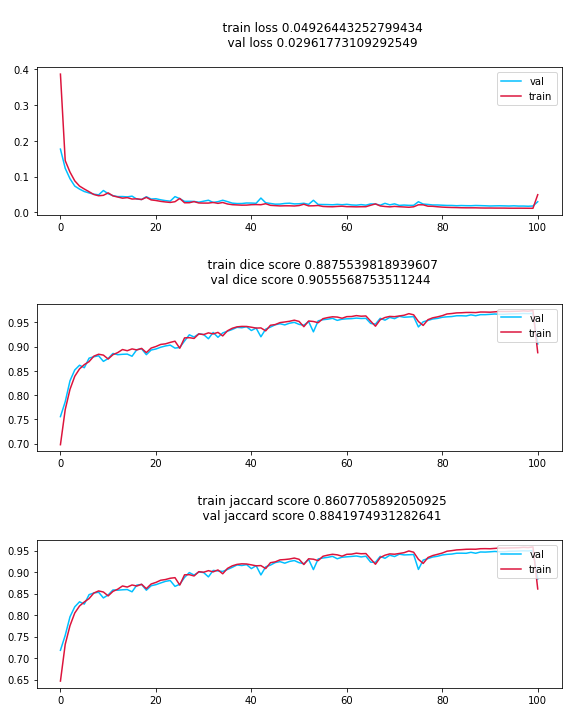


####################
Saved new checkpoint
####################


CPU times: user 15min 56s, sys: 5min 5s, total: 21min 2s
Wall time: 21min 15s


In [ ]:
%%time
trainer.train()

# Experiments and Results

In [ ]:
val_dataloader = get_dataloader(
    imgs_dir=config.path_to_imgs_dir,
    masks_dir=config.path_to_masks_dir,
    path_to_csv=config.path_to_csv,
    phase = "val",
    batch_size = 8,
    num_workers = 6,
    test_size = 0.2,
)

In [ ]:
%%time
dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(
    model, val_dataloader, ['lung', 'heart', 'trachea']
    )

CPU times: user 1min 38s, sys: 14.9 s, total: 1min 53s
Wall time: 1min 55s


In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['lung dice', 'heart dice', 'trachea dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['lung jaccard', 'heart jaccard', 'trachea jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['lung dice', 'lung jaccard', 
                                      'heart dice', 'heart jaccard', 
                                      'trachea dice', 'trachea jaccard']]
val_metics_df

,lung dice,lung jaccard,heart dice,heart jaccard,trachea dice,trachea jaccard
0,0.995929,0.991890,1.000000e+00,1.000000e+00,9.547920e-01,9.134948e-01
1,1.000000,1.000000,1.000000e+00,1.000000e+00,9.230769e-01,8.571429e-01
2,0.960790,0.924538,2.857143e-11,2.857143e-11,7.142857e-11,7.142857e-11
3,0.991927,0.983983,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
4,0.980867,0.962452,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...
3337,1.000000,1.000000,1.000000e+00,1.000000e+00,5.980861e-13,5.980861e-13
3338,0.951952,0.908309,1.000000e+00,1.000000e+00,2.020202e-12,2.020202e-12
3339,0.995000,0.990049,1.000000e+00,1.000000e+00,9.753846e-01,9.519520e-01
3340,0.997518,0.995049,1.000000e+00,1.000000e+00,9.805996e-01,9.619377e-01


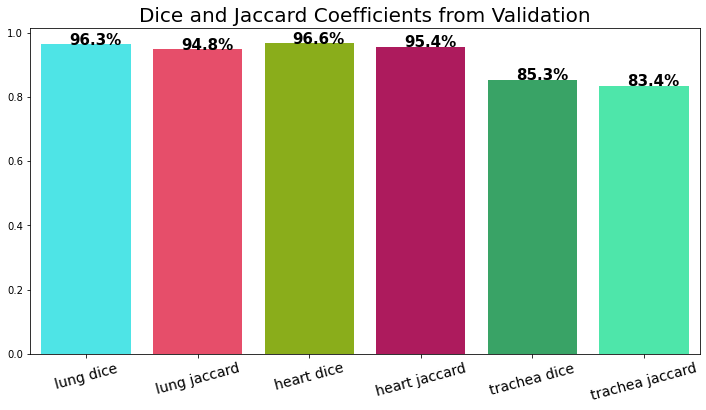

In [ ]:
colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF']
palette = sns.color_palette(colors, 6)

fig, ax = plt.subplots(figsize=(12, 6));
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), palette=palette, ax=ax);
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15);
ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
        percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
        x = p.get_x() + p.get_width() / 2 - 0.15
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result1.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

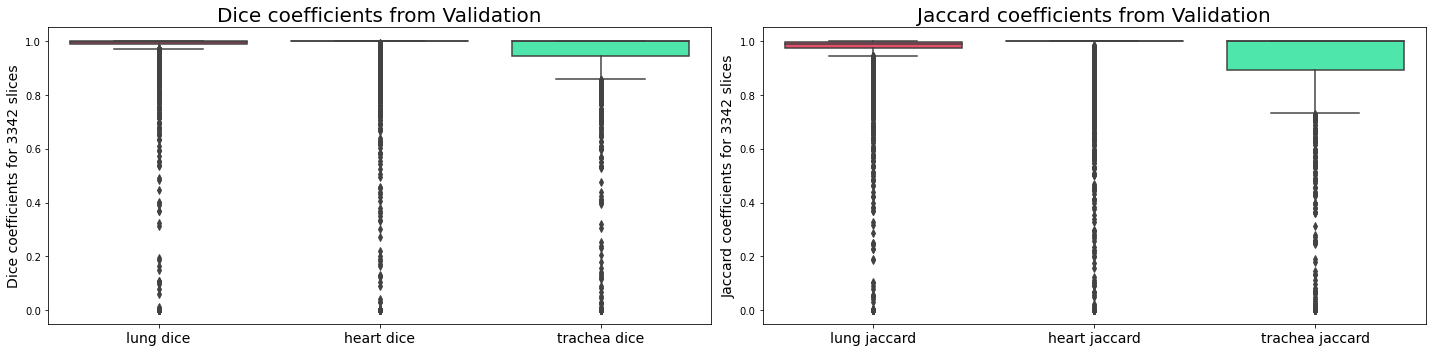

In [ ]:
colors = ['#35FCFF', '#FF355A', '#28B463', '#35FFAF', '#96C503', '#C5035B']
palette = sns.color_palette(colors[1::], 3)

fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.boxplot(data=dice_df, palette=palette, ax=ax[0])
ax[0].set_ylabel("Dice coefficients for 3342 slices", fontsize=14)
ax[0].set_title("Dice coefficients from Validation", fontsize=20)
ax[0].set_xticklabels(dice_df.columns, fontsize=14)

sns.boxplot(data=iou_df, palette=palette, ax=ax[1])
ax[1].set_ylabel("Jaccard coefficients for 3342 slices", fontsize=14)
ax[1].set_title("Jaccard coefficients from Validation", fontsize=20)
ax[1].set_xticklabels(iou_df.columns, fontsize=14)
plt.tight_layout()

fig.savefig("result2.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result2.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

and train history logs 

In [ ]:
train_logs = pd.read_csv(config.train_logs_path)
train_logs.head(5)

,train_loss,val_loss,train_dice,val_dice,train_jaccard,val_jaccard
0,0.386394,0.176678,0.697667,0.755589,0.646303,0.717975
1,0.144522,0.123104,0.769935,0.786307,0.731782,0.752826
2,0.112448,0.093943,0.811846,0.829476,0.775296,0.795960
3,0.087972,0.073344,0.838840,0.851835,0.804823,0.819167
4,0.073297,0.064866,0.854065,0.861600,0.821115,0.830928


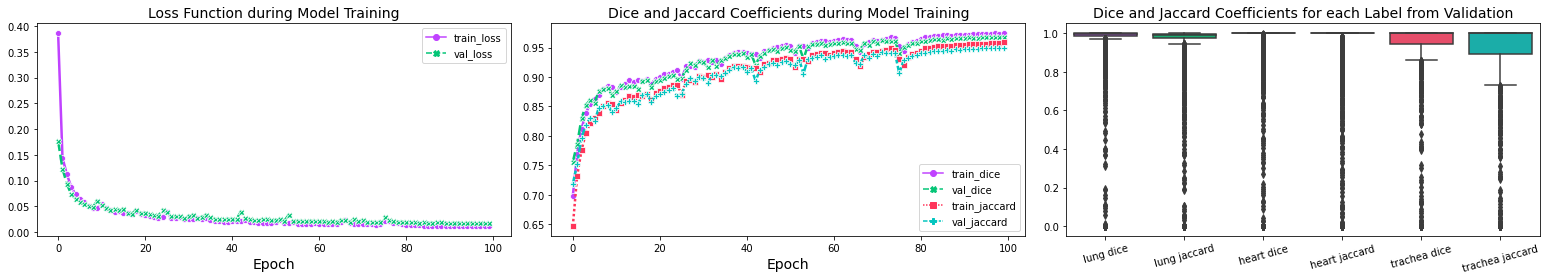

In [ ]:
colors = ['#C042FF', '#03C576FF', '#FF355A', '#03C5BF', '#96C503', '#C5035B']
palettes = [sns.color_palette(colors, 2),
            sns.color_palette(colors, 4), 
            sns.color_palette(colors[:2]+colors[-2:] + colors[2:-2], 6)]
            
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

sns.lineplot(data=train_logs.iloc[:, :2], palette=palettes[0], markers=True, ax=ax[0], linewidth=2.5,)
ax[0].set_title("Loss Function during Model Training", fontsize=14)
ax[0].set_xlabel("Epoch", fontsize=14)

sns.lineplot(data=train_logs.iloc[:, 2:], palette=palettes[1], markers=True, ax=ax[1], linewidth=2.5, legend="full")
ax[1].set_title("Dice and Jaccard Coefficients during Model Training", fontsize=14)
ax[1].set_xlabel("Epoch", fontsize=14)

sns.boxplot(data=val_metics_df.iloc[:,:], palette=palettes[2], ax=ax[2])
ax[2].set_title("Dice and Jaccard Coefficients for each Label from Validation", fontsize=14)
ax[2].set_xticklabels(val_metics_df.columns, fontsize=10, rotation=15)

plt.tight_layout()
fig.savefig("result3.png", format="png",  pad_inches=0.2, transparent=False, bbox_inches='tight')
fig.savefig("result3.svg", format="svg",  pad_inches=0.2, transparent=False, bbox_inches='tight')

Now let's make a video with overlapped masks for each slice of one id CT 

In [ ]:
df = pd.read_csv(config.path_to_csv)
df["Id"] = df['ImageId'].apply(lambda x: x.split("_")[0])

id_ = 'ID00400637202305055099402'
full_scan_example = df.loc[df['Id'] == id_].reset_index(drop=True)
full_scan_example 

,ImageId,MaskId,Id
0,ID00400637202305055099402_0.jpg,ID00400637202305055099402_mask_0.jpg,ID00400637202305055099402
1,ID00400637202305055099402_1.jpg,ID00400637202305055099402_mask_1.jpg,ID00400637202305055099402
2,ID00400637202305055099402_2.jpg,ID00400637202305055099402_mask_2.jpg,ID00400637202305055099402
3,ID00400637202305055099402_3.jpg,ID00400637202305055099402_mask_3.jpg,ID00400637202305055099402
4,ID00400637202305055099402_4.jpg,ID00400637202305055099402_mask_4.jpg,ID00400637202305055099402
...,...,...,...
260,ID00400637202305055099402_260.jpg,ID00400637202305055099402_mask_260.jpg,ID00400637202305055099402
261,ID00400637202305055099402_261.jpg,ID00400637202305055099402_mask_261.jpg,ID00400637202305055099402
262,ID00400637202305055099402_262.jpg,ID00400637202305055099402_mask_262.jpg,ID00400637202305055099402
263,ID00400637202305055099402_263.jpg,ID00400637202305055099402_mask_263.jpg,ID00400637202305055099402


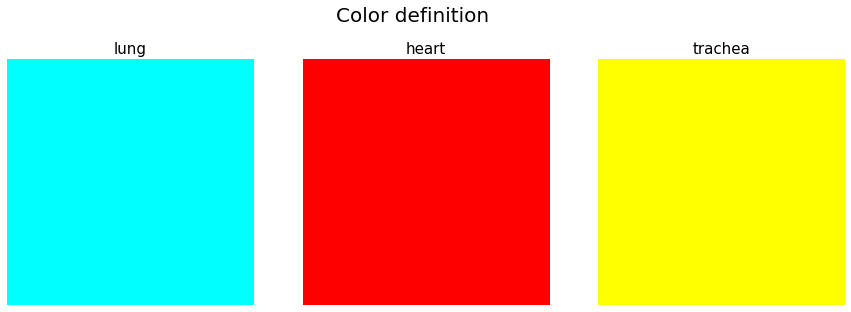

In [ ]:
get_color_info()

### Ground Truth

In [ ]:
PATH_TO_SAVE = id_ + "_ground_truth"

if not os.path.exists(PATH_TO_SAVE):
    os.mkdir(PATH_TO_SAVE)
    print(f"Folder {PATH_TO_SAVE} created.")

get_overlaid_masks_on_full_ctscan(ct_scan_id_df=full_scan_example,
                                  path_to_save="./" +PATH_TO_SAVE,
                                  root_imgs_dir = '../input/chest-ct-segmentation/images/images/',        
                                  root_masks_dir = '../input/chest-ct-segmentation/masks/masks/')


Folder ID00400637202305055099402_ground_truth created.


In [ ]:
%%time
create_video(path_to_imgs=PATH_TO_SAVE, video_name=id_+"_ground_truth", framerate=30)

CPU times: user 2.8 s, sys: 65.9 ms, total: 2.86 s
Wall time: 2.95 s


In [ ]:
# install any fonts
!wget -O bitwise.zip https://www.1001freefonts.com/d/8190/bitwise.zip
!unzip bitwise.zip

--2023-02-24 00:48:13--  https://www.1001freefonts.com/d/8190/bitwise.zip
Resolving www.1001freefonts.com (www.1001freefonts.com)... 104.26.0.140, 104.26.1.140, 172.67.72.212, ...
Connecting to www.1001freefonts.com (www.1001freefonts.com)|104.26.0.140|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /bitwise.font [following]
--2023-02-24 00:48:14--  https://www.1001freefonts.com/bitwise.font
Reusing existing connection to www.1001freefonts.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘bitwise.zip’

bitwise.zip             [ <=>                ]  45.73K  --.-KB/s    in 0.01s   

2023-02-24 00:48:14 (4.44 MB/s) - ‘bitwise.zip’ saved [46827]

Archive:  bitwise.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this

In [ ]:
%%bash
# to play in google colab had to recode
#https://ottverse.com/ffmpeg-drawtext-filter-dynamic-overlays-timecode-scrolling-text-credits/
ffmpeg -i 'ID00400637202305055099402_ground_truth.avi' -vf "drawtext=text='Ground Truth':x=195:y=8:fontsize=24:fontfile='./Bitwise.ttf':fontcolor='#FFFFFF'" -strict -2 'transcoded_video1.mp4'

ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1566210161358/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, avi, from 'ID00400637202305055099402_ground_truth.avi':
  Metadata:


CalledProcessError: Command 'b'# to play in google colab had to recode\n#https://ottverse.com/ffmpeg-drawtext-filter-dynamic-overlays-timecode-scrolling-text-credits/\nffmpeg -i \'ID00400637202305055099402_ground_truth.avi\' -vf "drawtext=text=\'Ground Truth\':x=195:y=8:fontsize=24:fontfile=\'./Bitwise.ttf\':fontcolor=\'#FFFFFF\'" -strict -2 \'transcoded_video1.mp4\'\n'' returned non-zero exit status 1.

In [ ]:
show_video("transcoded_video1.mp4")

### Prediction

In [ ]:
imgs, predictions = get_id_predictions(net=model,
                                       ct_scan_id_df=full_scan_example,
                                       root_imgs_dir=config.path_to_imgs_dir)

device: cuda


In [ ]:
%%time
PATH_TO_SAVE = id_ + "_predictions"

if not os.path.exists(PATH_TO_SAVE):
    os.mkdir(PATH_TO_SAVE)
    print(f"Folder {PATH_TO_SAVE} created.")

_= [
    get_overlaid_masks_on_image(one_slice_image=image,
                                one_slice_mask=mask, 
                                write=True,
                                path_to_save=PATH_TO_SAVE,
                                name_to_save= str(i_name)
                                ) 
    for i_name, (image, mask) in enumerate(zip(imgs, predictions))
    ]

Folder ID00400637202305055099402_predictions created.
CPU times: user 1min 10s, sys: 570 ms, total: 1min 11s
Wall time: 1min 11s


In [ ]:
%%time
create_video(path_to_imgs=PATH_TO_SAVE, video_name=id_+"_predictions", framerate=30)

CPU times: user 2.4 s, sys: 57.6 ms, total: 2.46 s
Wall time: 2.46 s


In [ ]:
%%bash
ffmpeg -i 'ID00400637202305055099402_predictions.avi' -vf "drawtext=text='Prediction':x=195:y=8:fontsize=24:fontfile='./Bitwise.ttf':fontcolor='#FFFFFF'" -strict -2 'transcoded_video2.mp4'

ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1566210161358/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, avi, from 'ID00400637202305055099402_predictions.avi':
  Metadata:
 

CalledProcessError: Command 'b'ffmpeg -i \'ID00400637202305055099402_predictions.avi\' -vf "drawtext=text=\'Prediction\':x=195:y=8:fontsize=24:fontfile=\'./Bitwise.ttf\':fontcolor=\'#FFFFFF\'" -strict -2 \'transcoded_video2.mp4\'\n'' returned non-zero exit status 1.

In [ ]:
show_video("transcoded_video2.mp4")

Merging video with ground truth slices and video with predicted slices

In [ ]:
%%bash
#  https://unix.stackexchange.com/questions/233832/merge-two-video-clips-into-one-placing-them-next-to-each-other
ffmpeg \
  -i transcoded_video1.mp4 \
  -i transcoded_video2.mp4 \
  -filter_complex '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=W/2:0[vid]' \
  -map [vid] \
  -c:v libx264 \
  -crf 23 \
  -preset veryfast \
  result.mp4

ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/opt/conda --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1566210161358/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x558188f93f80] Format mov,mp4,m4a,3gp,3g2,mj2 dete

CalledProcessError: Command 'b"#  https://unix.stackexchange.com/questions/233832/merge-two-video-clips-into-one-placing-them-next-to-each-other\nffmpeg \\\n  -i transcoded_video1.mp4 \\\n  -i transcoded_video2.mp4 \\\n  -filter_complex '[0:v]pad=iw*2:ih[int];[int][1:v]overlay=W/2:0[vid]' \\\n  -map [vid] \\\n  -c:v libx264 \\\n  -crf 23 \\\n  -preset veryfast \\\n  result.mp4\n"' returned non-zero exit status 1.

In [ ]:
show_video("result.mp4")

In [ ]:
# !rm -r ID00400637202305055099402_ground_truth
# !rm -r ID00400637202305055099402_predictions